# Aprendizado não-supervisionado

## Nem sempre teremos uma variável alvo para estimar. Para esse tipo de problema temos os algoritmos de **Aprendizado Não-supervisionado**.

### Aprendizado Não-supervisionado

Os algoritmos de aprendizado não-supervisionado estão ainda divididos em dois grupos: Os algoritmos de clusterização (agrupamento) e os de redução de dimensão.

Nessa aula iremos ver um algoritmo de cada tipo! 

Para desenvolver nossa aula, seremos apresentados a um novo *Dataset*, o Movielens!

Depois de tratarmos o dataset novo iremos ver dois algoritmos de aprendizado não supervisionado: K-means e PCA

## Dataset

Vamos explorar esse novo *dataset*.

Primeiro vamos carregar os dados


In [1]:
import pandas
movies = pandas.read_csv("movie_lens_completo.csv")
movies.head()

,id,title,release_date,imdb_url,user_id,item_id,rating,timestamp,age,sex,ocuppation,zip_code,faixa_etaria,genero
0,1,Toy Story,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,244,1,4,1997-11-27 04:20:05,28,M,technician,80525,20-29,Animation
1,1,Toy Story,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,298,1,5,1998-01-06 22:34:21,44,M,executive,01581,40-49,Animation
2,1,Toy Story,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,253,1,5,1998-04-03 18:34:27,26,F,librarian,22903,20-29,Animation
3,1,Toy Story,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,305,1,5,1998-02-01 08:52:33,23,M,programmer,94086,20-29,Animation
4,1,Toy Story,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,6,1,4,1997-12-31 20:17:58,42,M,executive,98101,40-49,Animation


Descrição dos dados:
* id - identificador do filme
* title - titulo do filme
* release_date - data de lançamento do filme
* imdb_url - url da página do IMDb do filme
* user_id - id do usuário que fez a avaliação do filme
* item_id - id do item avaliado
* rating - avaliação do filme. Valor de 0 a 5
* timestamp - data em que a avaliação foi feita
* age - idade do usuário que avaliou 
* sex - gênero do usuário que avaliou
* ocuppation - profissão do avaliador
* zip_code - CEP do avaliador
* faixa_etaria - faixa etária que o avaliador se encaixa (gerado no pre-processamento)

Vamos **contar** os dados

In [2]:
qnt_dados = movies.shape[0]
print("Dados: {}".format(qnt_dados))

qnt_movies = movies["id"].unique().size
print("Movies: {}".format(qnt_movies))

qnt_users = movies["user_id"].unique().size
print("Users: {}".format(qnt_users))


Dados: 100000
Movies: 1682
Users: 943


Vamos checar a **existência de dados nulos**

In [3]:
movies.isnull().sum()

id               0
title            0
release_date     9
imdb_url        13
user_id          0
item_id          0
rating           0
timestamp        0
age              0
sex              0
ocuppation       0
zip_code         0
faixa_etaria     0
genero           0
dtype: int64

Temos poucos dados nulos perto do conjunto. Então não vamos tratar agora os dados nulos.

**Não podemos esquecer deles futuramente**

Vamos ver a distribuição de `rating`

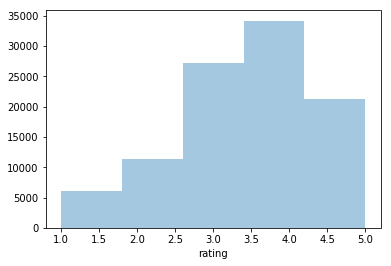

In [4]:
%matplotlib inline

import seaborn as sns
sns.distplot(movies["rating"],bins=5,kde=False)

Vamos fazer um boxplot para ver a distribuição das avaliações por sexo:

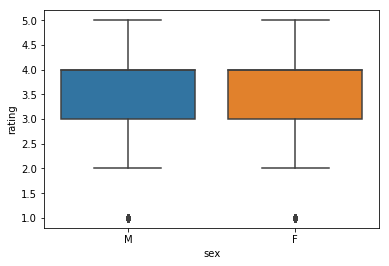

In [5]:
sns.boxplot(x="sex", y="rating",data=movies)

A distribuição por sexo parece não variar muito.

## <font color='blue'>Vamos fazer o mesmo gráfico para as profissões com relação aos ratings!</font>
![alt text](https://static.vix.com/pt/sites/default/files/styles/large/public/a/atrasada-relogio-pulso-1116-1400x800.jpg?itok=qv3gUH6U)

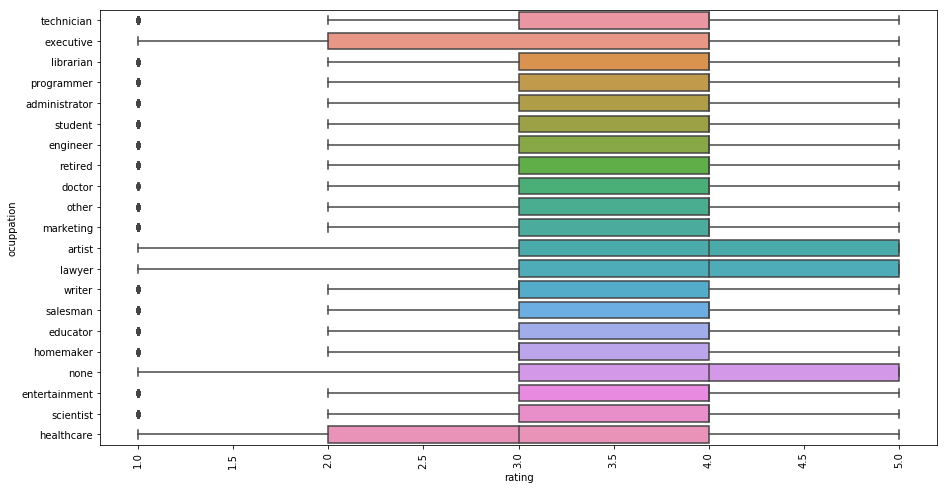

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
sns.boxplot(x="rating", y="ocuppation",data=movies)

Vamos ver agora a **variação da idade por profissão**

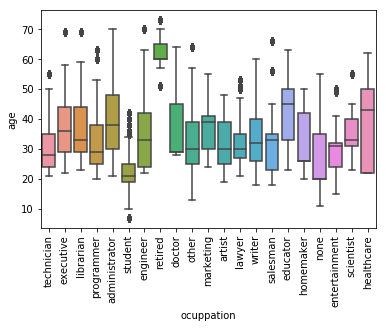

In [7]:
import matplotlib.pyplot as plt
plt.xticks(rotation=90)

sns.boxplot(x="ocuppation", y="age",data=movies)

Existe uma série de outras visualizações que podemos realizar com os dados. Entretanto iremos continuar para o tratamento dos dados.

**Vamos transformar os valores das colunas `sex`, `ocuppation` e `genero` em colunas a partir do get_dummies**

In [8]:
movies_dmy = pandas.get_dummies(movies, 
                                columns=["sex","ocuppation","genero"]
                               )
movies_dmy.head()

,id,title,release_date,imdb_url,user_id,item_id,rating,timestamp,age,zip_code,...,genero_Film-Noir,genero_Horror,genero_Musical,genero_Mystery,genero_Romance,genero_Sci-Fi,genero_Thriller,genero_War,genero_Western,genero_unknown
0,1,Toy Story,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,244,1,4,1997-11-27 04:20:05,28,80525,...,0,0,0,0,0,0,0,0,0,0
1,1,Toy Story,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,298,1,5,1998-01-06 22:34:21,44,01581,...,0,0,0,0,0,0,0,0,0,0
2,1,Toy Story,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,253,1,5,1998-04-03 18:34:27,26,22903,...,0,0,0,0,0,0,0,0,0,0
3,1,Toy Story,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,305,1,5,1998-02-01 08:52:33,23,94086,...,0,0,0,0,0,0,0,0,0,0
4,1,Toy Story,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,6,1,4,1997-12-31 20:17:58,42,98101,...,0,0,0,0,0,0,0,0,0,0


In [9]:
movies_dmy.columns

Index(['id', 'title', 'release_date', 'imdb_url', 'user_id', 'item_id',
       'rating', 'timestamp', 'age', 'zip_code', 'faixa_etaria', 'sex_F',
       'sex_M', 'ocuppation_administrator', 'ocuppation_artist',
       'ocuppation_doctor', 'ocuppation_educator', 'ocuppation_engineer',
       'ocuppation_entertainment', 'ocuppation_executive',
       'ocuppation_healthcare', 'ocuppation_homemaker', 'ocuppation_lawyer',
       'ocuppation_librarian', 'ocuppation_marketing', 'ocuppation_none',
       'ocuppation_other', 'ocuppation_programmer', 'ocuppation_retired',
       'ocuppation_salesman', 'ocuppation_scientist', 'ocuppation_student',
       'ocuppation_technician', 'ocuppation_writer', 'genero_Action',
       'genero_Adventure', 'genero_Animation', 'genero_Children's',
       'genero_Comedy', 'genero_Crime', 'genero_Documentary', 'genero_Drama',
       'genero_Fantasy', 'genero_Film-Noir', 'genero_Horror', 'genero_Musical',
       'genero_Mystery', 'genero_Romance', 'genero_Sci-Fi',

## <font color='blue'>Vamos enriquecer mais nossos dados! Vamos carregar um dataset da relação dos `zip_code` e estados, para que possamos saber o **estado de cada usuário**!</font>

Para fazer isso basta carregar o banco de zip codes disponível em <span class="importante"> http://bit.ly/2nEJKar </span>, e em seguida realizar um `merge` pelo `zip_code`.

![alt text](https://static.vix.com/pt/sites/default/files/styles/large/public/a/atrasada-relogio-pulso-1116-1400x800.jpg?itok=qv3gUH6U)



In [10]:
#trocar a url para uma legivel
zipcode = pandas.read_csv("http://bit.ly/2nEJKar")
zipcode.head()

,Zipcode,ZipCodeType,City,State,LocationType,Lat,Long,Location,Decommisioned,TaxReturnsFiled,EstimatedPopulation,TotalWages
0,705,STANDARD,AIBONITO,PR,PRIMARY,18.14,-66.26,NA-US-PR-AIBONITO,False,NaN,NaN,NaN
1,610,STANDARD,ANASCO,PR,PRIMARY,18.28,-67.14,NA-US-PR-ANASCO,False,NaN,NaN,NaN
2,611,PO BOX,ANGELES,PR,PRIMARY,18.28,-66.79,NA-US-PR-ANGELES,False,NaN,NaN,NaN
3,612,STANDARD,ARECIBO,PR,PRIMARY,18.45,-66.73,NA-US-PR-ARECIBO,False,NaN,NaN,NaN
4,601,STANDARD,ADJUNTAS,PR,PRIMARY,18.16,-66.72,NA-US-PR-ADJUNTAS,False,NaN,NaN,NaN


In [11]:
zipcode_state = zipcode[["Zipcode","State"]]
zipcode_state.head()

,Zipcode,State
0,705,PR
1,610,PR
2,611,PR
3,612,PR
4,601,PR


In [12]:
movies["zip_code"].head()

0    80525
1    01581
2    22903
3    94086
4    98101
Name: zip_code, dtype: object

In [13]:
zipcode_state["Zipcode"].head()

0    705
1    610
2    611
3    612
4    601
Name: Zipcode, dtype: int64

<p class="atencao"> Atenção!</p>
A coluna `Zipcode` do dataset que carregamos é do tipo `int64` e a coluna `zip_code` do dataset de filmes é do tipo `string (object)`.

Só vamos conseguir fazer o `merge` se os dois forem do mesmo tipo. Então vamos converter a coluna `Zipcode` do dataset de estados para `string`

In [14]:
zipcode_state_final = zipcode_state.copy()
zipcode_state_final["Zipcode"] = zipcode_state["Zipcode"].astype('str')

In [15]:
pandas.merge?

In [16]:
movies_with_state = pandas.merge(movies_dmy,
                                 zipcode_state_final,
                                 how="left",
                                 left_on="zip_code",
                                 right_on="Zipcode")
movies_with_state.head()

,id,title,release_date,imdb_url,user_id,item_id,rating,timestamp,age,zip_code,...,genero_Musical,genero_Mystery,genero_Romance,genero_Sci-Fi,genero_Thriller,genero_War,genero_Western,genero_unknown,Zipcode,State
0,1,Toy Story,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,244,1,4,1997-11-27 04:20:05,28,80525,...,0,0,0,0,0,0,0,0,80525,CO
1,1,Toy Story,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,298,1,5,1998-01-06 22:34:21,44,01581,...,0,0,0,0,0,0,0,0,NaN,NaN
2,1,Toy Story,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,253,1,5,1998-04-03 18:34:27,26,22903,...,0,0,0,0,0,0,0,0,22903,VA
3,1,Toy Story,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,305,1,5,1998-02-01 08:52:33,23,94086,...,0,0,0,0,0,0,0,0,94086,CA
4,1,Toy Story,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,6,1,4,1997-12-31 20:17:58,42,98101,...,0,0,0,0,0,0,0,0,98101,WA


In [17]:
movies_with_state.isnull().sum()

id                              0
title                           0
release_date                    9
imdb_url                       13
user_id                         0
item_id                         0
rating                          0
timestamp                       0
age                             0
zip_code                        0
faixa_etaria                    0
sex_F                           0
sex_M                           0
ocuppation_administrator        0
ocuppation_artist               0
ocuppation_doctor               0
ocuppation_educator             0
ocuppation_engineer             0
ocuppation_entertainment        0
ocuppation_executive            0
ocuppation_healthcare           0
ocuppation_homemaker            0
ocuppation_lawyer               0
ocuppation_librarian            0
ocuppation_marketing            0
ocuppation_none                 0
ocuppation_other                0
ocuppation_programmer           0
ocuppation_retired              0
ocuppation_sal

Vamos ver a distribuição dos dados pelos estados

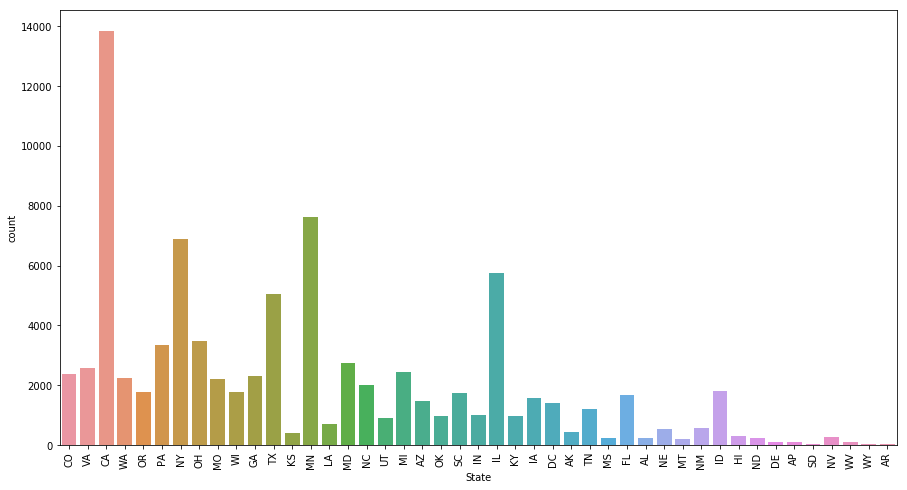

In [18]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.xticks(rotation=90)

sns.countplot(movies_with_state["State"])

## <font color='blue'>Vamos agora, transformar os valores da coluna `State` em valores numéricos</font>
![alt text](https://static.vix.com/pt/sites/default/files/styles/large/public/a/atrasada-relogio-pulso-1116-1400x800.jpg?itok=qv3gUH6U)

In [19]:
movies_final = pandas.get_dummies(movies_with_state, columns=["State"])
movies_final.head()

,id,title,release_date,imdb_url,user_id,item_id,rating,timestamp,age,zip_code,...,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_WA,State_WI,State_WV,State_WY
0,1,Toy Story,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,244,1,4,1997-11-27 04:20:05,28,80525,...,0,0,0,0,0,0,0,0,0,0
1,1,Toy Story,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,298,1,5,1998-01-06 22:34:21,44,01581,...,0,0,0,0,0,0,0,0,0,0
2,1,Toy Story,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,253,1,5,1998-04-03 18:34:27,26,22903,...,0,0,0,0,0,1,0,0,0,0
3,1,Toy Story,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,305,1,5,1998-02-01 08:52:33,23,94086,...,0,0,0,0,0,0,0,0,0,0
4,1,Toy Story,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,6,1,4,1997-12-31 20:17:58,42,98101,...,0,0,0,0,0,0,1,0,0,0


Agora, terminamos de enrriquecer nossos dados! \o/

Vamos salvar o dataset para não perdermos nosso avanço!

In [20]:
movies_final.to_csv("movielens_final.csv", index=False)

----

## K-means

K-means é um algoritmo de agrupamento. A idéia é agrupar os dados por **proximidade** a um ponto central. Para falarmos sobre **proximidade** devemos entender o conceito de **distância e similaridade** 

### Similaridade e Distância

Vamos analisar o conceito de distância inicialmente!

Vamos imaginar um conjunto de dados que pode ser representado por dois valores numéricos, $X_1$ e $X_2$

In [21]:
dados_matriz = [[1,2],
                [2,1],
                [2,3.2],
                [3,2.5],
                [4,1],
                [1.2,1],
                [0.2,7.3]]

dados = pandas.DataFrame(dados_matriz,columns=["X1","X2"])
dados

,X1,X2
0,1.0,2.0
1,2.0,1.0
2,2.0,3.2
3,3.0,2.5
4,4.0,1.0
5,1.2,1.0
6,0.2,7.3


Vamos ver esses dados em um gráfico com os valores indicando suas posições

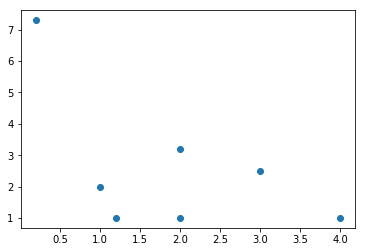

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(dados["X1"],dados["X2"],"o")

Nesse caso, com apenas duas colunas, podemos medir a distância entre dois pontos visualmente.
A distância em linha reta desses pontos pode ser calculada a partir da fórmula da **distância euclidiana**

$D(a,b) = \sqrt{(a_{x1} - b_{x1})^2 + (a_{x2} - b_{x2})^2}$

Vamos fazer então a função que calcula a distância euclidiana

In [23]:
def dist(a,b):
    return ( (a[0]-b[0])**2 + (a[1]-b[1])**2 )**0.5

In [24]:
dado_a = dados_matriz[0]
dado_b = dados_matriz[2]
d_ab = dist(dado_a,dado_b)

print("""
a distância de {} a {} é {}
""".format(dado_a,dado_b,d_ab))


a distância de [1, 2] a [2, 3.2] é 1.562049935181331



Esse é o caso de um dado com dois atributos (duas dimensões). Podemos generalizar o cálculo para a quantidade de dimensões do dado. A distância de dois dados que tem $n$ atributos é

$D(a,b) = \sqrt{ \sum_{i=1}^{n}{(a_{xi} - b_{xi})^2}}$

In [25]:
def dist_n(a,b):
    somatorio = 0.0
    for i in range(len(a)):
        somatorio = somatorio + (a[i]-b[i])**2
    return somatorio**0.5

In [26]:
dist_n([1,2],[1,2])

0.0

<p class="atencao"> Não existe apenas a distância euclidiana!</p>

Agora que entendemos a distância entre dados, vamos fazer uma aplicação baseada nisso

**Vamos encontrar o usuários mais próximo de um usuário selecionado do dataset `movie_lens`**

Vamos inicialmente selecionar apenas as colunas que são relativas ao usuário

Temos muitas colunas que começam com `State_` e `ocuppation_`. 

In [27]:
movies_final.columns

Index(['id', 'title', 'release_date', 'imdb_url', 'user_id', 'item_id',
       'rating', 'timestamp', 'age', 'zip_code', 'faixa_etaria', 'sex_F',
       'sex_M', 'ocuppation_administrator', 'ocuppation_artist',
       'ocuppation_doctor', 'ocuppation_educator', 'ocuppation_engineer',
       'ocuppation_entertainment', 'ocuppation_executive',
       'ocuppation_healthcare', 'ocuppation_homemaker', 'ocuppation_lawyer',
       'ocuppation_librarian', 'ocuppation_marketing', 'ocuppation_none',
       'ocuppation_other', 'ocuppation_programmer', 'ocuppation_retired',
       'ocuppation_salesman', 'ocuppation_scientist', 'ocuppation_student',
       'ocuppation_technician', 'ocuppation_writer', 'genero_Action',
       'genero_Adventure', 'genero_Animation', 'genero_Children's',
       'genero_Comedy', 'genero_Crime', 'genero_Documentary', 'genero_Drama',
       'genero_Fantasy', 'genero_Film-Noir', 'genero_Horror', 'genero_Musical',
       'genero_Mystery', 'genero_Romance', 'genero_Sci-Fi',

Vamos selecionar essas colunas filtrando entre todas

In [28]:
all_columns = list(movies_final.columns)

occupation_state_columns = []
for c in all_columns:
    if c.startswith("State_") or c.startswith("ocuppation_"):
        occupation_state_columns.append(c)
        
print("""
As colunas selecionadas foram: \n {}
""".format(occupation_state_columns))


As colunas selecionadas foram: 
 ['ocuppation_administrator', 'ocuppation_artist', 'ocuppation_doctor', 'ocuppation_educator', 'ocuppation_engineer', 'ocuppation_entertainment', 'ocuppation_executive', 'ocuppation_healthcare', 'ocuppation_homemaker', 'ocuppation_lawyer', 'ocuppation_librarian', 'ocuppation_marketing', 'ocuppation_none', 'ocuppation_other', 'ocuppation_programmer', 'ocuppation_retired', 'ocuppation_salesman', 'ocuppation_scientist', 'ocuppation_student', 'ocuppation_technician', 'ocuppation_writer', 'State_AK', 'State_AL', 'State_AP', 'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_DC', 'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MD', 'State_MI', 'State_MN', 'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NM', 'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_PA', 'State_SC', 'State_SD', 'State_TN', 'State_TX', 'State_UT'

Além dessas colunas também temos as colunas `age`,`sex_F`,`sex_M` e `user_id` que devem ser concatenadas com as que selecionamos até agora

In [29]:
columns_to_select = ["age",
                     "sex_F",
                     "sex_M",
                     "user_id"] + occupation_state_columns

In [30]:
columns_to_select

['age',
 'sex_F',
 'sex_M',
 'user_id',
 'ocuppation_administrator',
 'ocuppation_artist',
 'ocuppation_doctor',
 'ocuppation_educator',
 'ocuppation_engineer',
 'ocuppation_entertainment',
 'ocuppation_executive',
 'ocuppation_healthcare',
 'ocuppation_homemaker',
 'ocuppation_lawyer',
 'ocuppation_librarian',
 'ocuppation_marketing',
 'ocuppation_none',
 'ocuppation_other',
 'ocuppation_programmer',
 'ocuppation_retired',
 'ocuppation_salesman',
 'ocuppation_scientist',
 'ocuppation_student',
 'ocuppation_technician',
 'ocuppation_writer',
 'State_AK',
 'State_AL',
 'State_AP',
 'State_AR',
 'State_AZ',
 'State_CA',
 'State_CO',
 'State_DC',
 'State_DE',
 'State_FL',
 'State_GA',
 'State_HI',
 'State_IA',
 'State_ID',
 'State_IL',
 'State_IN',
 'State_KS',
 'State_KY',
 'State_LA',
 'State_MD',
 'State_MI',
 'State_MN',
 'State_MO',
 'State_MS',
 'State_MT',
 'State_NC',
 'State_ND',
 'State_NE',
 'State_NM',
 'State_NV',
 'State_NY',
 'State_OH',
 'State_OK',
 'State_OR',
 'State_PA

Podemos agora selecionar apenas as colunas de usuário do dataset

In [31]:
df_user = movies_final[columns_to_select]
df_user.head()

,age,sex_F,sex_M,user_id,ocuppation_administrator,ocuppation_artist,ocuppation_doctor,ocuppation_educator,ocuppation_engineer,ocuppation_entertainment,...,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_WA,State_WI,State_WV,State_WY
0,28,0,1,244,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,44,0,1,298,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,26,1,0,253,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,23,0,1,305,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,42,0,1,6,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Como o dataset original registrava todas as avalições de uma mesma pessoa, existem registros duplicados. Devemos agora retirar os registros duplicados

In [32]:
df_user.shape

(100000, 70)

In [33]:
df_user_final = df_user.drop_duplicates()
df_user_final.shape

(943, 70)

Vamos, finalmente encontrar o usuário mais próximo do `the_chosen_one`

In [34]:
df_user_ml = df_user_final.drop("user_id", axis=1)

the_chosen_one = df_user_ml.loc[0]
others = df_user_ml.loc[1:]

# Lista de indices
indexes = others.index

# Variaveis auxiliares para encontrar o de menor distacia
index_min = indexes[0]
dist_min = dist_n(the_chosen_one,others.loc[index_min])

for i in indexes:
    some_user = others.loc[i]
    dist_local = dist_n(the_chosen_one,some_user)
    
    if(dist_local<dist_min):
        dist_min = dist_local
        index_min = i

Agora vamos ver a distância dos usuários de mais próximos

In [35]:
dist_min

1.0

In [36]:
index_min

376


## Centróide de um grupo
Outro conceito importante para a compreensão do algortimo é o conceito de `centróide`.

**Centróide** é um ponto calculado que representa o centro do conjunto. 

Um cálculo normal de centroide a média dos atributos. 

Para entender melhor, vamos calcular o centroid dos dados de atributo $X_1$ e $X_2$.

In [37]:
dados

,X1,X2
0,1.0,2.0
1,2.0,1.0
2,2.0,3.2
3,3.0,2.5
4,4.0,1.0
5,1.2,1.0
6,0.2,7.3


Vamos usar o Método `mean()` da coluna para encontrar a média dos valores

In [38]:
centroid_x1 = [dados["X1"].mean()]
centroid_x2 = [dados["X2"].mean()]
print("""
O centroid dos dados é [{},{}]
""".format(centroid_x1,centroid_x2))


O centroid dos dados é [[1.9142857142857141],[2.5714285714285716]]



Vamos plotar agora o grafico dos pontos para observar o posicionamento do centroid

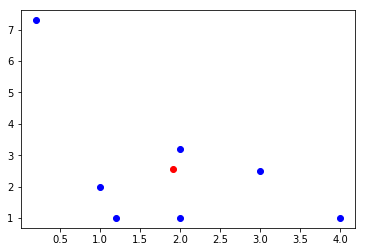

In [39]:
plt.plot(dados["X1"],dados["X2"],"ob")
plt.plot(centroid_x1,centroid_x2,"or")

Parece realmente representar o centro do conjunto

## <font color='blue'>Faça uma função que calcule o centróide de todas as colunas do movielens</font>
![alt text](https://static.vix.com/pt/sites/default/files/styles/large/public/a/atrasada-relogio-pulso-1116-1400x800.jpg?itok=qv3gUH6U)

In [40]:
def centroide(df):
    return df.mean()

In [41]:
dados.mean()

X1    1.914286
X2    2.571429
dtype: float64

In [42]:
def centroide(df):
    result = {}
    cols = list(df.columns)
    for c in cols:
        result[c] = df[c].mean()
    return result

In [43]:
centroide(df_user_final)

{'State_AK': 0.0053022269353128317,
 'State_AL': 0.0031813361611876989,
 'State_AP': 0.0010604453870625664,
 'State_AR': 0.0010604453870625664,
 'State_AZ': 0.014846235418875928,
 'State_CA': 0.12301166489925769,
 'State_CO': 0.021208907741251327,
 'State_DC': 0.014846235418875928,
 'State_DE': 0.0031813361611876989,
 'State_FL': 0.025450689289501591,
 'State_GA': 0.020148462354188761,
 'State_HI': 0.0021208907741251328,
 'State_IA': 0.014846235418875928,
 'State_ID': 0.007423117709437964,
 'State_IL': 0.053022269353128315,
 'State_IN': 0.0095440084835630972,
 'State_KS': 0.0042417815482502655,
 'State_KY': 0.01166489925768823,
 'State_LA': 0.0063626723223753979,
 'State_MD': 0.02863202545068929,
 'State_MI': 0.024390243902439025,
 'State_MN': 0.082714740190880168,
 'State_MO': 0.018027571580063628,
 'State_MS': 0.0031813361611876989,
 'State_MT': 0.0021208907741251328,
 'State_NC': 0.020148462354188761,
 'State_ND': 0.0021208907741251328,
 'State_NE': 0.0063626723223753979,
 'State_NM

Agora que sabemos encontrar o centróide de um conjunto, vamos ao conceito do algoritmo de `K-means`!

## O algortimo

O objetivo do algoritmo é : Encontrar K clusters (agrupamentos) dos dados.

Passo-a-passo: 

    1 . Iniciamos K pontos aleatórios que serão considerados os centróides dos grupos.
    
    2 . A matriz de distâncias é montada. 
    
  Supondo que queremos montar `K` grupos e temos `n` dados 
    
|       | $C_1$      | $C_2$      | ... |   $C_k$    |
|-------|------------|------------|-----|------------|
| $u_1$ |d($u_1$,$C_1$)|d($u_1$,$C_2$)| ... |d($u_1$,$C_k$)|
| $u_2$ |d($u_2$,$C_1$)|d($u_2$,$C_2$)| ... |d($u_2$,$C_k$)|
|  ...  |    ...     |     ...    | ... |     ...    |
| $u_n$ |d($u_n$,$C_1$)|d($u_n$,$C_2$)| ... |d($u_n$,$C_k$)|

   Cada dado $u_i$ é considerado do cluster com menor distância do centróide
    
   3 . O Centróide real dos dados dos grupos é calculado
   
   4 . A matriz de distância é feita de novo, considerando os centroides calculados no passo 3.
       
       4.1 . Se algum dado mudar de cluster, o algoritmo volta ao passo 2, considerando esses centroides como os K centroides 
       
       4.2 . Se nenhum dado mudar de cluster, o algoritmo assume que encontrou os clusters!


![km](https://upload.wikimedia.org/wikipedia/commons/e/ea/K-means_convergence.gif)

Vamos agora criar os cluster dos dados fictícios 

In [44]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=0)
km = km.fit(dados)

Vamos agora pegar os centróides do modelo e plotar

In [45]:
centers = km.cluster_centers_
c_to_plot = centers.T

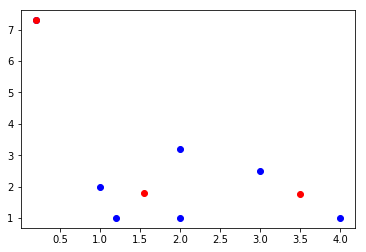

In [46]:
from matplotlib import pyplot as plt
plt.plot(dados["X1"],dados["X2"],'ob')
plt.plot(c_to_plot[0],c_to_plot[1],'or')

Vamos plotar agora cada cluster encontrado

In [47]:
def plot_clusters (df,km_model,colors=["r","b","g"],centroid_color = "k"):
    df_matrix = df.as_matrix()
    lines = df_matrix.shape[0]
    print(lines)
    labels = km_model.labels_
    for l in range(lines):
        label = labels[l]
        x = [df_matrix[l][0]]
        y = [df_matrix[l][1]]

        plt.plot(x,y,"o"+colors[label])
        
    centroides_t = km_model.cluster_centers_.T
    plt.plot(centroides_t[0],centroides_t[1],"*"+centroid_color)

7


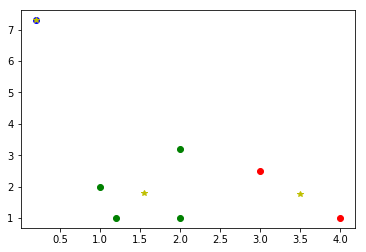

In [48]:
plot_clusters(dados,km,centroid_color="y")

## <font color='blue'>Apliquem o K-Means aos dados de usuário.</font>
![alt text](https://static.vix.com/pt/sites/default/files/styles/large/public/a/atrasada-relogio-pulso-1116-1400x800.jpg?itok=qv3gUH6U)
Contem a quantidade de dados em cada cluster.

Veja a distância entre os clusters (usando os centróides)

In [49]:
df_user_ml = df_user_final.drop("user_id", axis=1)

In [50]:
km_users = KMeans(n_clusters=3,random_state=0)
km_users = km_users.fit(df_user_ml)

In [51]:
labels = pandas.DataFrame(km_users.labels_,columns=["label"])
labels.groupby("label").size()

label
0    377
1    338
2    228
dtype: int64

In [52]:
centroides = km_users.cluster_centers_
d12 = dist_n(centroides[0],centroides[1])
d13 = dist_n(centroides[0],centroides[2])
d23 = dist_n(centroides[1],centroides[2])

print("""
D(c1,c2)={};
D(c1,c3)={};
D(c2,c3)={};
""".format(d12,d13,d23))


D(c1,c2)=12.257063642809737;
D(c1,c3)=28.905591121793687;
D(c2,c3)=16.652380985025722;



In [53]:
labels.size

943

Temos 69 dimensões. Não conseguimos plotar tantas dimensões =(

Muitas dimensões também podem causar problemas no treinamento de alguns algoritmos. 

Vamos agora aprender um algoritmo de redução de dimensão

# 4 - PCA

PCA (principal component analysis), é um algortimo de aprendizado não-supervisionado, que é usado para reduzir as dimensões dos dados.

Vamos ver um exemplo de diminuição de dimenção de 3D -> 2D

In [54]:
m_3d = [[1,2,3],
           [1.2,0.2,3.4],
           [9,1,2],
           [6,5,4],
           [7,2,4],
           [2,6,4],
           [4,7,8],
           [3,4,7]]
dados_3d = pandas.DataFrame(m_3d,columns=["X1","X2","X3"])
#dados_3d

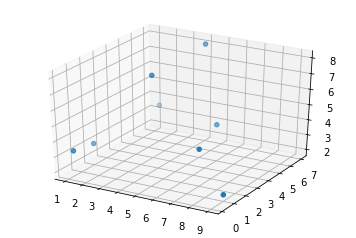

In [55]:
from mpl_toolkits import mplot3d


fig = plt.figure()
ax = plt.axes(projection='3d')


ax.scatter3D(dados_3d["X1"],dados_3d["X2"],dados_3d["X3"])

Os dados em 3D já podem dificultar a interpretação. 

**Iremos então diminuir para duas dimensões.**

In [56]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=2)
d_2d = pca_model.fit_transform(dados_3d)

In [57]:
dados_2d = pandas.DataFrame(d_2d,columns=["z1","z2"])
dados_2d

,z1,z2
0,-0.713962,3.618329
1,0.230960,4.385326
2,5.800960,-1.218929
3,0.584256,-2.123542
4,2.931190,-1.085438
5,-2.714040,0.183050
6,-3.782928,-3.303447
7,-2.336436,-0.455349


In [58]:
dados_3d

,X1,X2,X3
0,1.0,2.0,3.0
1,1.2,0.2,3.4
2,9.0,1.0,2.0
3,6.0,5.0,4.0
4,7.0,2.0,4.0
5,2.0,6.0,4.0
6,4.0,7.0,8.0
7,3.0,4.0,7.0


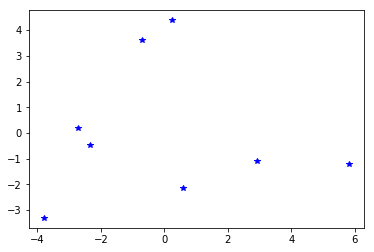

In [59]:
plt.plot(dados_2d["z1"],dados_2d["z2"],"*b")

<p class="atencao"> Importante!</p> 

<p class="importante"> Esses dados não são diretamente significativos! Eles representam as relações que os dados tem entre si em menos dimensões! </p>

## <font color='blue'>Vamos diminuir as dimensões dos dados de usuário para 2 dimensões e plotar os dados</font>
![alt text](https://static.vix.com/pt/sites/default/files/styles/large/public/a/atrasada-relogio-pulso-1116-1400x800.jpg?itok=qv3gUH6U)

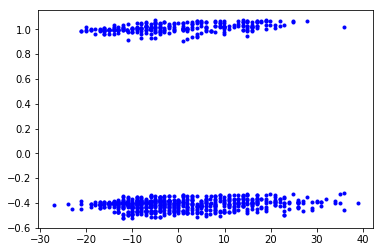

In [60]:
user_pca = PCA(n_components=2)
user_2d = user_pca.fit_transform(df_user_ml)

user_2d_to_plot = user_2d.T
plt.plot(user_2d_to_plot[0],user_2d_to_plot[1],".b")

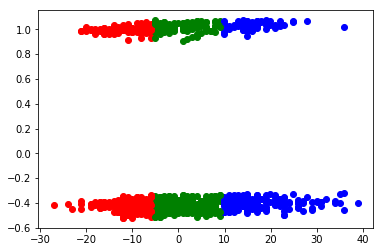

In [61]:
# Cores por label
colors=["r","g","b"]

# Numero de usuários
lines = user_2d.shape[0]

# Labels dos usuários
labels = km_users.labels_

# incluindo pontos no gráfico
for l in range(lines):
    label = labels[l]
    x = [user_2d[l][0]]
    y = [user_2d[l][1]]

    plt.plot(x,y,"o"+colors[label])
        